In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
import os

def confidence_interval(df, agg_col, metric_col):
    stats = df.groupby(agg_col)[metric_col].agg(['mean', 'count', 'std'])

    ci_hi = []
    ci_lo = []
    ci = []

    for i in stats.index:
        m, c, s = stats.loc[i]
        ci.append(1.96*s/math.sqrt(c))
        ci_hi.append(m + 1.96*s/math.sqrt(c))
        ci_lo.append(m - 1.96*s/math.sqrt(c))

    stats['ci'] = ci
    stats['ci_hi'] = ci_hi
    stats['ci_lo'] = ci_lo
    return stats

def unique(sequence):
    seen = set()
    return [x for x in sequence if not (x in seen or seen.add(x))]

In [ ]:
df_by_bias_type = {}
bias_types = ["random", "marpop", "marpos"]
for bias_type in bias_types:
    results_file = f"./data/KuaiRec/result/2025-01-07 06:22/2025-01-07 06:22_{bias_type}.parquet"
    df = pd.read_parquet(results_file)

    if "rating" in df.columns:
        df["sum_rating"] = df["rating"].apply(sum)
    if "sum_rating" in df.columns:
        df = df.query("sum_rating > 0")
    if "pscore" in df.columns:
        df.drop(["pscore"], axis=1, inplace=True)
    df_by_bias_type[bias_type] = df

print(df_by_bias_type.keys())
print(df.shape)
df.head(10)

dict_keys(['random', 'marpop', 'marpos'])
(8669184, 6)


,imprID,userID,evaluation,size_candidates,sum_rating,result_key
0,14,14,"{'group_auc': 0.3875, 'mean_mrr': 0.1068, 'mea...",37,32,train:lightfmf_full-test_marpos90:lightfmf_POP...
1,19,19,"{'group_auc': 0.5167, 'mean_mrr': 0.2307, 'mea...",17,12,train:lightfmf_full-test_marpos90:lightfmf_POP...
2,21,21,"{'group_auc': 0.5226, 'mean_mrr': 0.1223, 'mea...",36,31,train:lightfmf_full-test_marpos90:lightfmf_POP...
3,23,23,"{'group_auc': 0.5271, 'mean_mrr': 0.0907, 'mea...",53,48,train:lightfmf_full-test_marpos90:lightfmf_POP...
4,24,24,"{'group_auc': 0.4255, 'mean_mrr': 0.0716, 'mea...",52,47,train:lightfmf_full-test_marpos90:lightfmf_POP...
5,36,36,"{'group_auc': 0.5733, 'mean_mrr': 0.2073, 'mea...",20,15,train:lightfmf_full-test_marpos90:lightfmf_POP...
6,37,37,"{'group_auc': 0.3029, 'mean_mrr': 0.0958, 'mea...",40,35,train:lightfmf_full-test_marpos90:lightfmf_POP...
7,41,41,"{'group_auc': 0.7375, 'mean_mrr': 0.2034, 'mea...",21,16,train:lightfmf_full-test_marpos90:lightfmf_POP...
8,51,51,"{'group_auc': 0.4766, 'mean_mrr': 0.0853, 'mea...",52,47,train:lightfmf_full-test_marpos90:lightfmf_POP...
9,55,55,"{'group_auc': 0.4744, 'mean_mrr': 0.0842, 'mea...",48,43,train:lightfmf_full-test_marpos90:lightfmf_POP...


In [4]:
df_by_biastype_metric_biasmodel_sampler = {}
available_metrics = None
samplers = None
bias_models = None
recs = None

def extract_recname(c):
    return c[0:c.index("-test")].split(":")[1]

for bias_type, df in df_by_bias_type.items():
    df_byline = df.pivot(columns="result_key", values="evaluation")

    available_metrics = list(df_byline.iloc[0,0].keys())
    samplers = sorted({c.split("_")[-1] for c in df_byline.columns})
    bias_models = sorted({c[c.index("test_")+5: c.rindex(":")] for c in df_byline.columns})
    recs = sorted({extract_recname(c) for c in df_byline.columns})

    df_by_biastype_metric_biasmodel_sampler[bias_type] = {}
    for metric in available_metrics:

        df_by_biastype_metric_biasmodel_sampler[bias_type][metric] = {}
        df_single_metric = df_byline.map(
            lambda r: r.get(metric) if isinstance(r, dict) else r
        ).astype(float)
        for bias in bias_models:
            for sampler in samplers:
                rel_cols = [c for c in df_single_metric.columns if c.split("_")[-1] == sampler and f"test_{bias}" in c]
                df_single_metric_sampler = df_single_metric.loc[:, rel_cols].dropna()
                df_single_metric_sampler.rename(lambda c: extract_recname(c), axis=1, inplace=True)
                df_single_metric_sampler = df_single_metric_sampler[recs]

                df_single_metric_sampler["biastype"] = bias_type
                df_single_metric_sampler["metric"] = metric
                df_single_metric_sampler["bias"] = bias
                df_single_metric_sampler["sampler"] = sampler

                df_by_biastype_metric_biasmodel_sampler[bias_type][metric].setdefault(bias, {})
                df_by_biastype_metric_biasmodel_sampler[bias_type][metric][bias][sampler] = df_single_metric_sampler


print(available_metrics)
print(samplers)
print(bias_models)
print(recs)

df_by_biastype_metric_biasmodel_sampler[bias_type][metric][bias][sampler].head()

['group_auc', 'mean_mrr', 'mean_mrr@10', 'mean_mrr@100', 'mean_mrr@5', 'mean_mrr@50', 'ndcg@10', 'ndcg@100', 'ndcg@5', 'ndcg@50', 'precision@10', 'precision@100', 'precision@5', 'precision@50', 'recall@10', 'recall@100', 'recall@5', 'recall@50', 'unbiased_ndcg@10', 'unbiased_ndcg@100', 'unbiased_ndcg@5', 'unbiased_ndcg@50', 'unbiased_precision@10', 'unbiased_precision@100', 'unbiased_precision@5', 'unbiased_precision@50', 'unbiased_recall@10', 'unbiased_recall@100', 'unbiased_recall@5', 'unbiased_recall@50']
['CNCFULL', 'CNCRANDEXPO', 'CNCRANDOM@0', 'CNCRANDOM@1', 'CNCRANDOM@10', 'CNCRANDOM@100', 'CNCRANDOM@1000', 'CNCRANDOM@2', 'CNCRANDOM@20', 'CNCRANDOM@200', 'CNCRANDOM@5', 'CNCRANDOM@50', 'CNCRANDOM@500', 'EXPOSED', 'POPULARITY@1', 'POPULARITY@10', 'POPULARITY@100', 'POPULARITY@1000', 'POPULARITY@2', 'POPULARITY@20', 'POPULARITY@200', 'POPULARITY@5', 'POPULARITY@50', 'POPULARITY@500', 'POSITIVITY@1', 'POSITIVITY@10', 'POSITIVITY@100', 'POSITIVITY@1000', 'POSITIVITY@2', 'POSITIVITY@2

result_key,als_full,bpr_full,clickpop_full,lightfm_full,lightfmf_full,random_full,sar-cosine_full,sar-jaccard_full,biastype,metric,bias,sampler
0,0.1736,0.0000,0.5660,0.0000,0.0000,0.1127,0.1821,0.1821,marpos,unbiased_recall@50,marpos95,WTDH@500
1,0.3343,0.1957,1.0000,0.0000,0.0000,0.0693,0.2565,0.4312,marpos,unbiased_recall@50,marpos95,WTDH@500
2,0.0737,0.1056,1.0000,0.0834,0.0834,0.1465,0.1380,0.1708,marpos,unbiased_recall@50,marpos95,WTDH@500
3,0.1478,0.0000,0.2841,0.2360,0.2360,0.0920,0.2288,0.3264,marpos,unbiased_recall@50,marpos95,WTDH@500
4,0.1638,0.0000,0.4594,0.0070,0.0070,0.1658,0.1351,0.1351,marpos,unbiased_recall@50,marpos95,WTDH@500


In [5]:
# Add Ground Thruth (aka GT)
for bias_type, df_by_metric_biasmodel_sampler in df_by_biastype_metric_biasmodel_sampler.items():
    for metric, df_by_biasmodel_sampler in df_by_metric_biasmodel_sampler.items():
        gt_df = None
        for bias, df_by_sampler in df_by_biasmodel_sampler.items():
            if "".join([c for c in bias if c.isdigit()]) == "0":
                gt_df = df_by_sampler["CNCFULL"].copy()
                gt_df["sampler"] = "GT"
                break
        for bias, df_by_sampler in df_by_biasmodel_sampler.items():
            df_by_biastype_metric_biasmodel_sampler[bias_type][metric][bias]["GT"] = gt_df

In [6]:
samplers_blocks = {}
for sampler in samplers:
    if "@" in sampler:
        sampler_key = sampler.split("@")[0]
        if sampler_key not in samplers_blocks:
            samplers_blocks[sampler_key] = []
        samplers_blocks[sampler_key].append(sampler)

general_samplers = ["CNCFULL", "CNCRANDEXPO", "EXPOSED", "GT"]

for sampler_key, samplers_order in samplers_blocks.items():
    samplers_blocks[sampler_key] = dict(zip(
        sorted(samplers_order, key=lambda x: int(x.split("@")[-1])),
        list(range(len(samplers_order)))
    ))
    samplers_blocks[sampler_key].update(
        {s: len(samplers_order) + i for i, s in enumerate(general_samplers)}
    )

all_samplers_order = {}
size_last_sampler = 0
for i, (sampler_block, sampler_order) in enumerate(samplers_blocks.items()):
    for j, sampler in enumerate(sampler_order):
        all_samplers_order[sampler] = i * size_last_sampler + j
    size_last_sampler = len(sampler_order)

samplers_blocks

{'CNCRANDOM': {'CNCRANDOM@0': 0,
  'CNCRANDOM@1': 1,
  'CNCRANDOM@2': 2,
  'CNCRANDOM@5': 3,
  'CNCRANDOM@10': 4,
  'CNCRANDOM@20': 5,
  'CNCRANDOM@50': 6,
  'CNCRANDOM@100': 7,
  'CNCRANDOM@200': 8,
  'CNCRANDOM@500': 9,
  'CNCRANDOM@1000': 10,
  'CNCFULL': 11,
  'CNCRANDEXPO': 12,
  'EXPOSED': 13,
  'GT': 14},
 'POPULARITY': {'POPULARITY@1': 0,
  'POPULARITY@2': 1,
  'POPULARITY@5': 2,
  'POPULARITY@10': 3,
  'POPULARITY@20': 4,
  'POPULARITY@50': 5,
  'POPULARITY@100': 6,
  'POPULARITY@200': 7,
  'POPULARITY@500': 8,
  'POPULARITY@1000': 9,
  'CNCFULL': 10,
  'CNCRANDEXPO': 11,
  'EXPOSED': 12,
  'GT': 13},
 'POSITIVITY': {'POSITIVITY@1': 0,
  'POSITIVITY@2': 1,
  'POSITIVITY@5': 2,
  'POSITIVITY@10': 3,
  'POSITIVITY@20': 4,
  'POSITIVITY@50': 5,
  'POSITIVITY@100': 6,
  'POSITIVITY@200': 7,
  'POSITIVITY@500': 8,
  'POSITIVITY@1000': 9,
  'CNCFULL': 10,
  'CNCRANDEXPO': 11,
  'EXPOSED': 12,
  'GT': 13},
 'SKEW': {'SKEW@1': 0,
  'SKEW@2': 1,
  'SKEW@5': 2,
  'SKEW@10': 3,
  'SKEW@2

### Ranking Position (Tie Ratio)

In [7]:
rankdf_by_biastype_metric_biasmodel_samplerblock = {}

for bias_type, df_by_metric_biasmodel_sampler in df_by_biastype_metric_biasmodel_sampler.items():
    rankdf_by_biastype_metric_biasmodel_samplerblock[bias_type] = {}
    for metric, df_by_biasmodel_sampler in df_by_metric_biasmodel_sampler.items():
        rankdf_by_biastype_metric_biasmodel_samplerblock[bias_type][metric] = {}
        for bias, df_by_sampler in df_by_biasmodel_sampler.items():
            rankdf_by_biastype_metric_biasmodel_samplerblock[bias_type][metric][bias] = {}
            for sampler_key, samplers_order in samplers_blocks.items():
                list_rank_dfs = []
                for sampler in samplers_order:
                    list_rank_dfs.append(pd.concat([
                        df_by_sampler[sampler],
                        df_by_sampler[sampler].rank(
                            axis=1, method="min", numeric_only=True, na_option="bottom", ascending=False
                        ).rename(lambda n: "rank_" + n, axis=1).astype("int")
                    ], axis=1))
                rankdf_by_biastype_metric_biasmodel_samplerblock[bias_type][metric][bias][sampler_key] = pd.concat(list_rank_dfs)

rankdf_by_biastype_metric_biasmodel_samplerblock[bias_type][metric][bias][sampler_key].head(5)

result_key,als_full,bpr_full,clickpop_full,lightfm_full,lightfmf_full,random_full,sar-cosine_full,sar-jaccard_full,biastype,metric,bias,sampler,rank_als_full,rank_bpr_full,rank_clickpop_full,rank_lightfm_full,rank_lightfmf_full,rank_random_full,rank_sar-cosine_full,rank_sar-jaccard_full
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,marpos,unbiased_recall@50,marpos95,WTDH@1,1,1,1,1,1,1,1,1
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,marpos,unbiased_recall@50,marpos95,WTDH@1,1,1,1,1,1,1,1,1
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,marpos,unbiased_recall@50,marpos95,WTDH@1,1,1,1,1,1,1,1,1
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,marpos,unbiased_recall@50,marpos95,WTDH@1,1,1,1,1,1,1,1,1
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,marpos,unbiased_recall@50,marpos95,WTDH@1,1,1,1,1,1,1,1,1


#### Ranking Position Diff

In [ ]:
# Initialize a dictionary to store results
rank_comparison_results = []

for metric in available_metrics:
    for biastype in bias_types:
        rankdf_by_biasmodel_samplerblock = rankdf_by_biastype_metric_biasmodel_samplerblock[biastype][metric]

        for i, (sampler_block, sampler_order) in enumerate(samplers_blocks.items()):
            for j, (bias, rankdf_by_samplerblock) in enumerate(rankdf_by_biasmodel_samplerblock.items()):
                df_ranks = (
                    rankdf_by_samplerblock[sampler_block]
                    .query("sampler != 'CNCRANDOM@0'")
                    .set_index("sampler")
                )
                metric_cols = [c for c in df_ranks.select_dtypes("number").columns if not c.startswith("rank_")]
                df_ranks_group = df_ranks[metric_cols].groupby("sampler").mean().reset_index()
                df_rank_final = pd.concat([
                    pd.DataFrame(df_ranks_group["sampler"]),
                    df_ranks_group.rank(axis=1, numeric_only=True, ascending=False).astype(int)
                ], axis=1)

                # Extract GT (Ground Truth) ranks
                gt_ranks = df_rank_final.query("sampler == 'GT'")[metric_cols]
                if gt_ranks.shape[0] == 0:
                    continue  # Skip if GT is missing

                for _, row in df_rank_final.iterrows():
                    sampler = row["sampler"]
                    if sampler in general_samplers and "RANDOM" not in sampler_block:
                        continue  # Skip replication sampler
                    sampler_ranks = row[metric_cols]

                    # Calculate the difference in ranks between the sampler and GT
                    rank_diff = ((sampler_ranks - gt_ranks).abs() > 0).sum(axis=1).values[0].item()

                    # Store the result for later aggregation
                    rank_comparison_results.append({
                        "biastype": biastype,
                        "biasmodel": bias,
                        "metric": metric,
                        "sampler": sampler,
                        "rank_diff": rank_diff,
                        "rank_max": gt_ranks.shape[1]-1
                    })
rank_comparison_df = pd.DataFrame(rank_comparison_results)
rank_comparison_df.head()

,biastype,biasmodel,metric,sampler,rank_diff,rank_max
0,random,random0,group_auc,CNCFULL,0,7
1,random,random0,group_auc,CNCRANDEXPO,0,7
2,random,random0,group_auc,CNCRANDOM@1,2,7
3,random,random0,group_auc,CNCRANDOM@10,2,7
4,random,random0,group_auc,CNCRANDOM@100,0,7


In [9]:
# Initialize list to store results
rank_comparison_results_by_row = []
processed = {}
metric_cols = None

for metric in available_metrics:
    for biastype in bias_types:
        rankdf_by_biasmodel_samplerblock = rankdf_by_biastype_metric_biasmodel_samplerblock[biastype][metric]

        for i, (sampler_block, sampler_order) in enumerate(samplers_blocks.items()):
            for j, (bias, rankdf_by_samplerblock) in enumerate(rankdf_by_biasmodel_samplerblock.items()):
                df_ranks = rankdf_by_samplerblock[sampler_block]
                if metric_cols is None:
                    metric_cols = [
                        c for c in df_ranks.select_dtypes("number").columns if not c.startswith("rank_")
                    ]
                df_rank_final = pd.concat([
                    pd.DataFrame(df_ranks["sampler"]),
                    df_ranks[metric_cols].rank(axis=1, numeric_only=True, ascending=False).astype(int)
                ], axis=1)

                # Extract GT (Ground Truth) ranks
                gt_ranks = df_rank_final.query("sampler == 'GT'")[metric_cols]
                if gt_ranks.shape[0] == 0:
                    continue  # Skip if GT is missing

                for sampler in samplers_blocks[sampler_block]:
                    processed_key = f"{metric}_{bias}_{sampler}"
                    if processed_key in processed:
                        continue
                    processed[processed_key] = True

                    if sampler in general_samplers and "RANDOM" not in sampler_block:
                        continue
                    df_rankdiff_sampler = pd.DataFrame(
                        ((df_rank_final.query("sampler == @sampler")[metric_cols] - gt_ranks).abs() > 0).sum(axis=1),
                        columns=["rank_diff"]
                    )
                    df_rankdiff_sampler["biastype"] = biastype
                    df_rankdiff_sampler["biasmodel"] = bias
                    df_rankdiff_sampler["metric"] = metric
                    df_rankdiff_sampler["sampler"] = sampler
                    df_rankdiff_sampler["rank_max"] = gt_ranks.shape[1]
                    df_rankdiff_sampler["rank_diff_percentage"] = (1.0 - df_rankdiff_sampler["rank_diff"] / df_rankdiff_sampler["rank_max"]) * 100

                    rank_comparison_results_by_row.append(df_rankdiff_sampler)
rank_comparison_df_by_row = pd.concat(rank_comparison_results_by_row)
rank_comparison_df_by_row.head()

,rank_diff,biastype,biasmodel,metric,sampler,rank_max,rank_diff_percentage
0,0,random,random0,group_auc,CNCRANDOM@0,8,100.0
1,0,random,random0,group_auc,CNCRANDOM@0,8,100.0
2,0,random,random0,group_auc,CNCRANDOM@0,8,100.0
3,0,random,random0,group_auc,CNCRANDOM@0,8,100.0
4,0,random,random0,group_auc,CNCRANDOM@0,8,100.0


#### Q1: Discriminative Power

In [10]:
list_ties_df = []
for biastype, rankdf_by_metric_biasmodel_samplerblock in rankdf_by_biastype_metric_biasmodel_samplerblock.items():
    for metric, rankdf_by_biasmodel_samplerblock in rankdf_by_metric_biasmodel_samplerblock.items():
        for bias, rankdf_by_samplerblock in rankdf_by_biasmodel_samplerblock.items():
            for samplerblock, rankdf in rankdf_by_samplerblock.items():
                if "RANDOM" not in samplerblock:
                    # Skip replication sampler for ploting porpuse
                    df_ties = rankdf.query("sampler not in @general_samplers").copy()
                else:
                    df_ties = rankdf.copy()

                rank_cols = [c for c in df_ties.columns if "rank_" in c]
                count_rank = 1
                for c in df_ties.columns:
                    if "rank_" in c:
                        df_ties[count_rank] = (df_ties[rank_cols] == count_rank).sum(axis=1)
                        count_rank += 1

                df_ties["ties"] = 0
                df_ties["comps"] = (count_rank - 1) * (count_rank - 2) / 2
                for c in df_ties.columns:
                    if str(c).isdigit():
                        df_ties[f"{c}_norm"] = (df_ties[c] * (df_ties[c] - 1.0) / 2.0).abs()
                        df_ties["ties"] += df_ties[f"{c}_norm"]

                df_ties["tie_ratio"] = df_ties["ties"] / df_ties["comps"]

                list_ties_df.append(df_ties)

df_ties = pd.concat(list_ties_df)
df_ties.head()

result_key,als_full,bpr_full,clickpop_full,lightfm_full,lightfmf_full,random_full,sar-cosine_full,sar-jaccard_full,biastype,metric,...,comps,1_norm,2_norm,3_norm,4_norm,5_norm,6_norm,7_norm,8_norm,tie_ratio
0,0.3966,0.5866,0.4358,0.9553,0.7989,1.0000,0.0279,0.0168,random,group_auc,...,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0750,0.0750,0.8000,0.0000,0.0000,0.4250,0.5250,0.2750,random,group_auc,...,28.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.071429
2,0.9196,0.6607,0.7366,0.2768,0.2768,0.3929,0.3036,0.3839,random,group_auc,...,28.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.035714
3,0.5704,0.1742,0.8831,0.0143,0.0143,0.6205,0.2673,0.2816,random,group_auc,...,28.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.035714
4,0.6839,0.3404,0.8146,0.0517,0.0517,0.2462,0.7842,0.7872,random,group_auc,...,28.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.035714


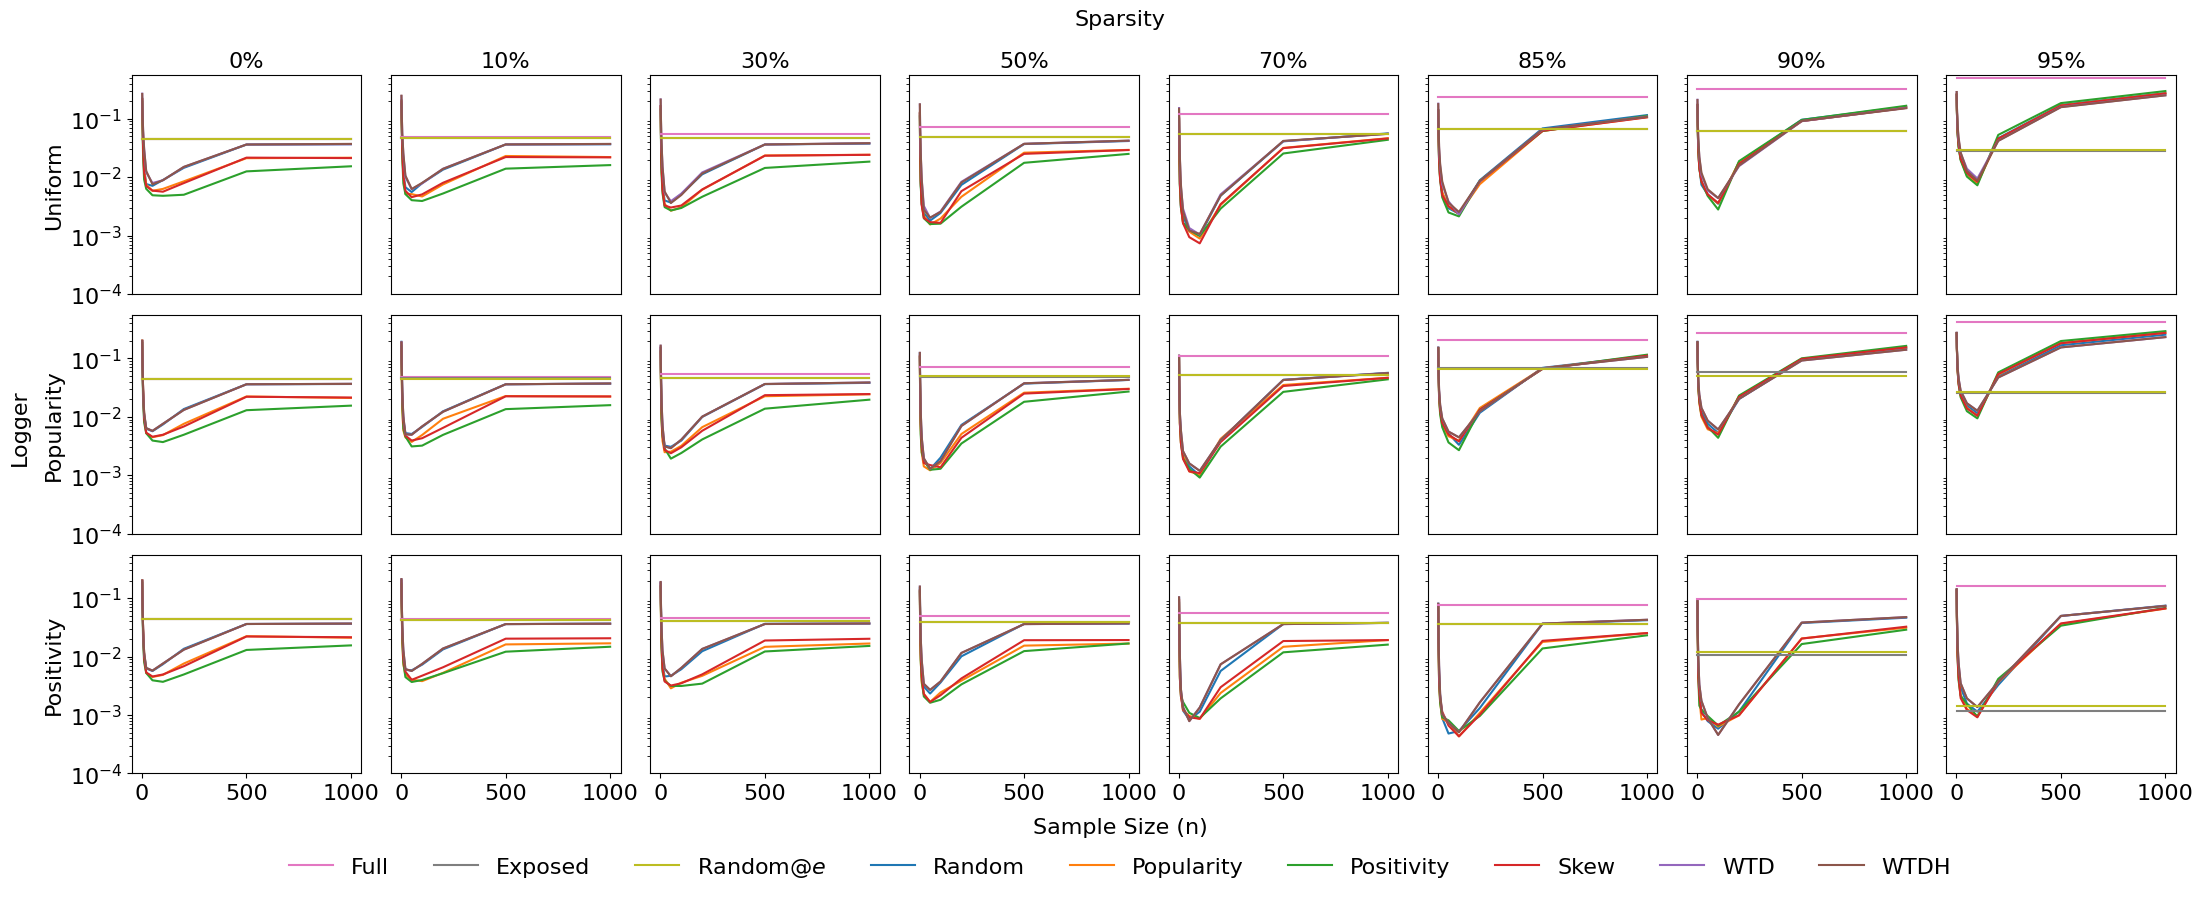

In [ ]:
def format_sampler_name(c, return_at=False):
    if not return_at:
        c = c.split("@")[0]

    c = c.split("-")[-1].replace("CNC", "").capitalize().replace("Randexpo", "Random@$e$")
    if c == "Gt":
        c = "GT"
    if c.startswith("Wtd"):
        c = c.upper()
    if c.startswith("Pop"):
        c = "Popularity"
    if c.startswith("Pos"):
        c = "Positivity"
    
    if "@" in c and return_at:
        c += ("@" + c.split("@")[-1] if return_at else "")
    return c

plt.rcParams.update({'font.size': 16})

def sort_sampler_index(s):
    sort_key = []
    if "GT" in s:
        sort_key.append("A")
    elif "FULL" in s:
        sort_key.append("B")
    elif "EXPOSED" in s:
        sort_key.append("C")
    elif "RANDEXPO" in s:
        sort_key.append("CA")
    else:
        sort_key.append("D" + s.split("@")[0])
    if "@" in s:
        sort_key.append(-int(s.split("@")[-1]))
    else:
        sort_key.append(0)
    sort_key.append(s)
    return tuple(sort_key)

def sort_legend(handle, labels):
    expected_order = {"GT": 0, "Full": 1, "Exposed": 2, "Random@$e$": 3, "Random@$n$": 4, "Popularity": 5, "Positivity": 6, "Skew": 7, "WTD": 8, "WTDH": 9}
    sorted_indices = sorted(range(len(labels)), key=lambda i: expected_order.get(labels[i], len(expected_order)))
    sorted_handles = [handle[i] for i in sorted_indices]
    sorted_labels = [labels[i] for i in sorted_indices]
    return sorted_handles, sorted_labels

handles = None
labels = None

percentages_to_plot = [0, 10, 30, 50, 70, 85, 90, 95]

ncols = len(bias_types)
fig, axes = plt.subplots(nrows=len(bias_types), ncols=len(percentages_to_plot), figsize=(22, 8))

default_cols = ["CNCFULL", "EXPOSED", "CNCRANDEXPO"]

for i, biastype in enumerate(bias_types):
    for metric in available_metrics:
        if metric != "ndcg@100":
            continue

        df_ties_plot = df_ties.query(f"metric == '{metric}' and sampler != 'CNCRANDOM@0'").copy()
        df_ties_plot["sampler_size"] = df_ties_plot["sampler"].apply(lambda r: int(r.split("@")[-1]) if "@" in r else 1000)
        df_ties_plot = (
            df_ties_plot
            .drop("sampler_size", axis=1)
            .groupby(["sampler", "bias"]).mean(["tie_ratio"])
        )

        vmax = df_ties_plot["tie_ratio"].max()
        df_ties_plot = df_ties_plot.pivot_table(index="sampler", columns="bias", values="tie_ratio")
        df_ties_plot["sort_index"] = df_ties_plot.index.map(lambda s: sort_sampler_index(s))
        
        df_ties_plot = (
            df_ties_plot
            .sort_values("sort_index", axis=0)
            .sort_index(na_position="first", axis=1)
            .drop("sort_index", axis=1)
        )

    xtickslabels = [str(100 - int("".join([c for c in s if c.isdigit()]))) + "%" for s in df_ties_plot.columns]
    grid_label = "".join([c for c in biastype if not c.isdigit()]).capitalize()
    if grid_label == "Marpos":
        grid_label = "Positivity"
    if grid_label == "Marpop":
        grid_label = "Popularity"
    if grid_label == "Random":
        grid_label = "Uniform"

    ytickslabels = []
    for c in df_ties_plot.index:
        c = c.split("-")[-1].replace("CNC", "").capitalize().replace("Randexpo", "Rand@$|E_u|$")
        if c == "Gt":
            c = "GT"
        if c.startswith("Wtd"):
            c = c.upper()
        if c.startswith("Rand"):
            c = "Rand@" + c.split("@")[-1]
        if c.startswith("Pop"):
            c = "Pop@" + c.split("@")[-1]
        if c.startswith("Pos"):
            c = "Pos@" + c.split("@")[-1]
        if c.startswith("Full"):
            c = "$L$"
        ytickslabels.append(c)
    ytickslabels2 = [c.split("-")[0] for c in df_ties_plot.index]

    df_ties_plot["sampler"] = df_ties_plot.index.str.split("-").str[-1]
    df_ties_plot["at"] = df_ties_plot["sampler"].apply(lambda s: int(s.split("@")[-1]) if "@" in s else -1)

    no_at_ties_plot = df_ties_plot[df_ties_plot["at"] == -1].copy()
    df_ties_plot = df_ties_plot[df_ties_plot["at"] != -1].copy()

    unique_ats = unique(df_ties_plot["at"].values)
    list_new_corrdfs = []
    for at in unique(df_ties_plot["at"].values):
        corrdf_aux = no_at_ties_plot.copy()
        corrdf_aux["at"] = at
        list_new_corrdfs.append(corrdf_aux)
    df_ties_plot = pd.concat([df_ties_plot] + list_new_corrdfs)

    df_ties_plot["sampler"] = df_ties_plot["sampler"].apply(lambda s: format_sampler_name(s))
    df_ties_plot = df_ties_plot.query("sampler != 'GT'").copy()
    for j, p in enumerate(percentages_to_plot):
        ax = axes[i][j]
        ax = sns.lineplot(df_ties_plot, x="at", y=biastype + str(p), hue="sampler", ax=ax)
        ax.set_ylim(0.0001, 0.55)
        ax.set_yscale("log")
        
        if i == 0:
            ax.set_title(f"{p}%", fontsize=16)
        if i == len(bias_types) - 1:
            ax.set_xlabel("")
        else:
            ax.xaxis.set_tick_params(length=0, labelbottom=False)
            ax.set_xlabel("")
            ax.set_xticklabels([])
        
        if j == 0:
            ax.set_ylabel(grid_label, fontsize=16)
        else:
            ax.yaxis.set_tick_params(length=0, labelbottom=False)
            ax.set_ylabel("")
            ax.set_yticklabels([])

        handles, labels = ax.get_legend_handles_labels()
        ax.legend_.remove()

fig.legend(*sort_legend(handles, labels), loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=len(handles), frameon=False, fontsize=16)
fig.tight_layout(w_pad=0.3, h_pad=0.3)

# Add general labels for the grid
fig.text(0.5, 1.01, "Sparsity", ha='center', va='center', fontsize=16)  # General x-axis label at the 
fig.text(0.5, 0.0, "Sample Size (n)", ha='center', va='center', fontsize=16)  # General x-axis label at the top
fig.text(0.0, 0.5, "Logger", ha='center', va='center', rotation='vertical', fontsize=16)  # General y-axis label

fig.show()

fig.savefig(os.path.join("q1_discriminative_line.pdf"), dpi=1300, bbox_inches="tight", pad_inches=0.05)

### Position-Based Kendall Correlation ($L$)

In [ ]:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corrwith.html
# {‘pearson’, ‘kendall’, ‘spearman’}
import os
from concurrent.futures import as_completed, ProcessPoolExecutor

q2_kendalldf_by_biastype_metric_biasmodel_samplerblock = {}

def compute_kendalltau(df1, df2, colname, key):
    return key, pd.DataFrame(df1.corrwith(df2, method="kendall", axis=1), columns=[colname])

with ProcessPoolExecutor(max_workers=int(os.cpu_count() * 0.9)) as executor:
    for bias_type, df_by_metric_biasmodel_sampler in df_by_biastype_metric_biasmodel_sampler.items():
        q2_kendalldf_by_biastype_metric_biasmodel_samplerblock[bias_type] = {}
        for metric, df_by_biasmodel_sampler in df_by_metric_biasmodel_sampler.items():
            if ("ndcg" not in metric and "recall" not in metric) or "10" not in metric: # FIXME
                continue

            q2_kendalldf_by_biastype_metric_biasmodel_samplerblock[bias_type][metric] = {}
            for bias, df_by_sampler in df_by_biasmodel_sampler.items():
                q2_kendalldf_by_biastype_metric_biasmodel_samplerblock[bias_type][metric][bias] = {}
                future_to_sampler = []
                for sampler_key, samplers_order in samplers_blocks.items():
                    for sampler1 in samplers_order:
                        rankdf_sampler1 = df_by_sampler[sampler1][recs].rank(
                            axis=1, method="min", numeric_only=True, na_option="bottom", ascending=False
                        ).astype("int")

                        if rankdf_sampler1.shape[0] == 0:
                            continue

                        rankdf_gt = df_by_sampler["CNCFULL"][recs].rank(
                            axis=1, method="min", numeric_only=True, na_option="bottom", ascending=False
                        ).astype("int")

                        future_to_sampler.append(
                            executor.submit(
                                compute_kendalltau, rankdf_sampler1, rankdf_gt, sampler1, sampler_key
                            )
                        )

                corrdf_by_samplerkey = {}
                for future in as_completed(future_to_sampler):
                    sampler_key, corr_df = future.result()
                    corrdf_by_samplerkey.setdefault(sampler_key, [])
                    corrdf_by_samplerkey[sampler_key].append(corr_df)

                for sampler_key, list_corr in corrdf_by_samplerkey.items():
                    q2_kendalldf_by_biastype_metric_biasmodel_samplerblock[bias_type][metric][bias][sampler_key] = pd.concat(list_corr, axis=1)

q2_kendalldf_by_biastype_metric_biasmodel_samplerblock[bias_type]["ndcg@100"][bias][sampler_key].head(5)

,WTDH@500,WTDH@5,WTDH@1,WTDH@2,WTDH@200,CNCRANDEXPO,WTDH@50,WTDH@10,GT,WTDH@20,WTDH@1000,WTDH@100,CNCFULL,EXPOSED
0,0.885270,0.869318,0.117670,0.718132,0.642540,0.718132,0.718132,0.793725,0.192450,0.793725,0.920000,0.869318,1.0,0.718132
1,0.851852,0.545545,-0.113228,0.148148,0.909241,0.836502,0.836502,0.618284,0.777778,0.836502,0.925926,0.763763,1.0,0.981981
2,0.885270,0.642540,0.326599,0.680000,0.642540,0.718132,0.793725,0.718132,0.500370,0.718132,0.731310,0.415761,1.0,0.566947
3,0.925926,0.691023,0.592593,0.814815,0.836502,0.763763,0.836502,0.618284,0.777778,0.836502,1.000000,0.836502,1.0,0.545545
4,0.738549,0.644658,0.383761,0.287213,0.644658,0.644658,0.725241,0.725241,0.738549,0.725241,0.902671,0.725241,1.0,0.805823


#### Q2: Fidelity

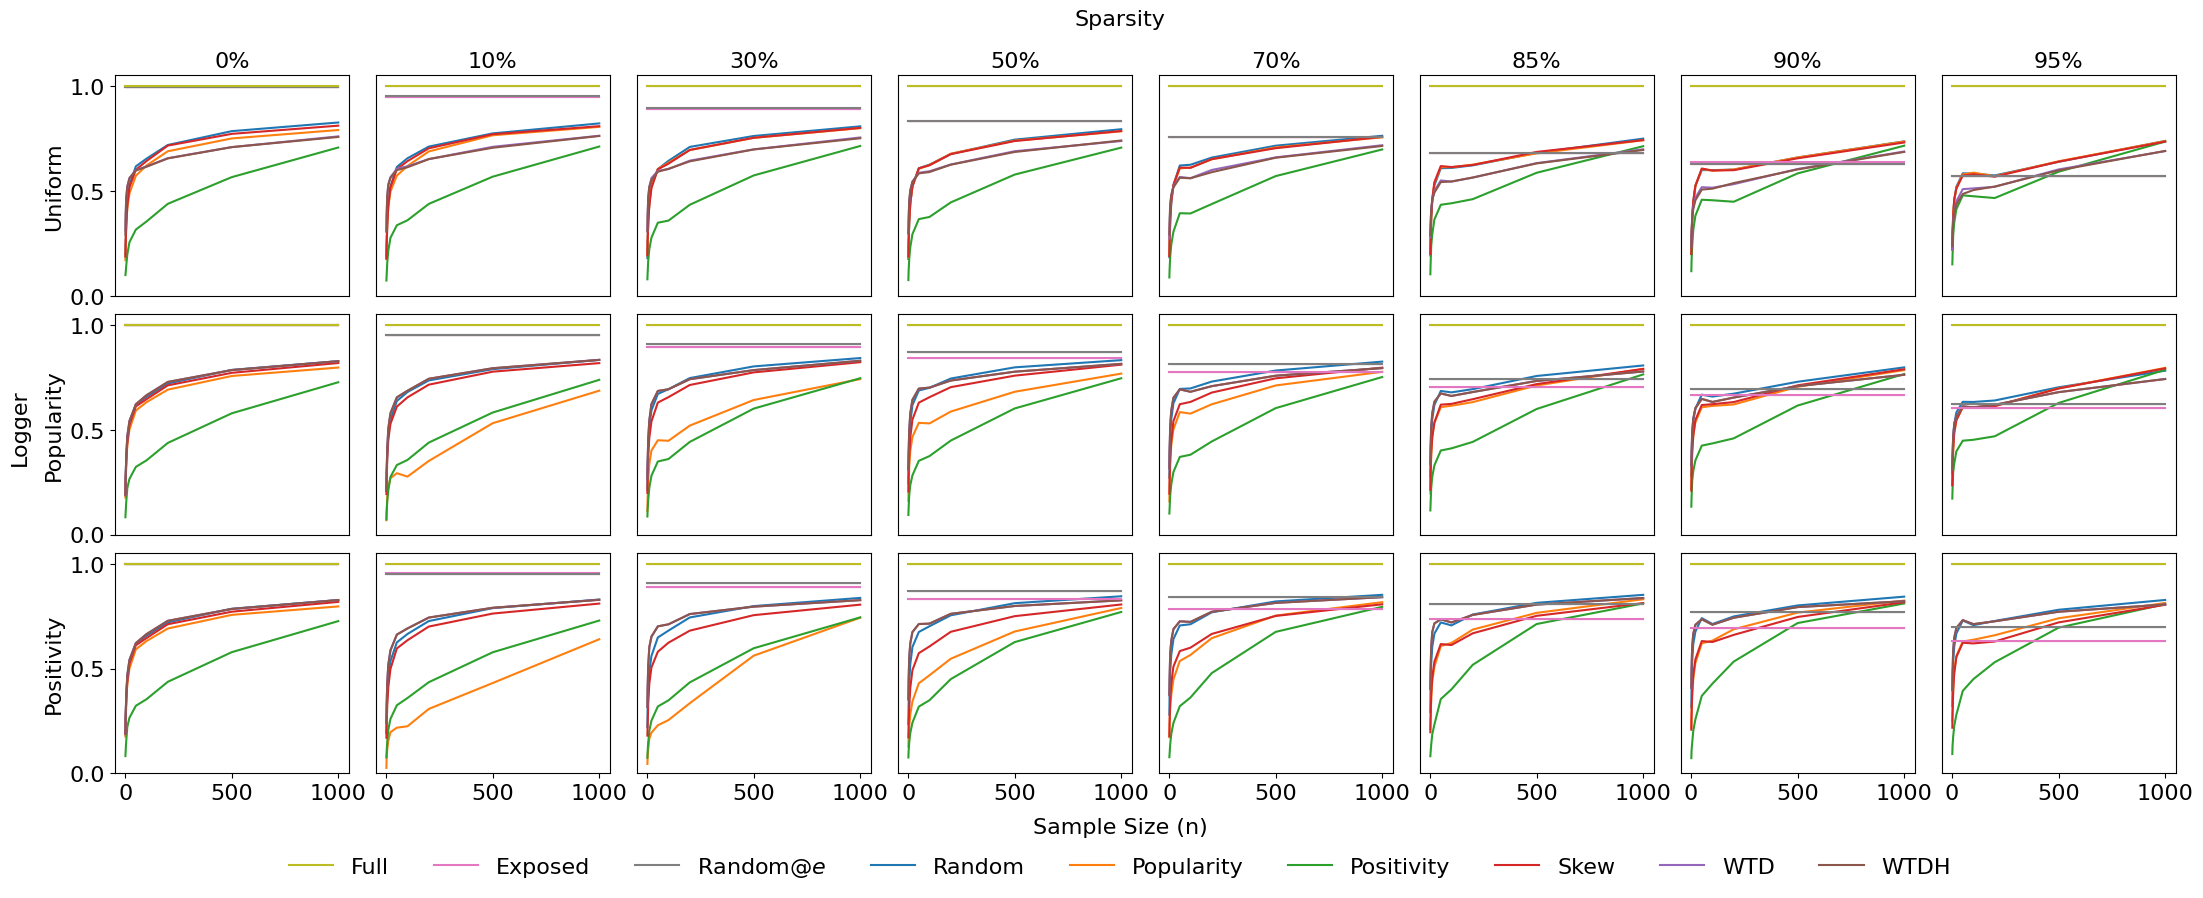

In [ ]:
def format_sampler_name(c, return_at=False):
    if not return_at:
        c = c.split("@")[0]

    c = c.split("-")[-1].replace("CNC", "").capitalize().replace("Randexpo", "Random@$e$")
    if c == "Gt":
        c = "GT"
    if c.startswith("Wtd"):
        c = c.upper()
    if c.startswith("Pop"):
        c = "Popularity"
    if c.startswith("Pos"):
        c = "Positivity"
    
    if "@" in c and return_at:
        c += ("@" + c.split("@")[-1] if return_at else "")
    return c

def sort_legend(handle, labels):
    expected_order = {"GT": 0, "Full": 1, "Exposed": 2, "Random@$e$": 3, "Random": 4, "Popularity": 5, "Positivity": 6, "Skew": 7, "WTD": 8, "WTDH": 9}
    sorted_indices = sorted(range(len(labels)), key=lambda i: expected_order.get(labels[i], len(expected_order)))
    sorted_handles = [handle[i] for i in sorted_indices]
    sorted_labels = [labels[i] for i in sorted_indices]
    return sorted_handles, sorted_labels

plt.rcParams.update({'font.size': 16})

handles = None
labels = None

percentages_to_plot = [0, 10, 30, 50,70, 85, 90, 95]

ncols = len(bias_types)
fig, axes = plt.subplots(nrows=len(bias_types), ncols=len(percentages_to_plot), figsize=(22, 8))#, width_ratios=[1.05, 1, 1, 1, 1])

default_cols = ["CNCFULL", "EXPOSED", "CNCRANDEXPO"]

for i, biastype in enumerate(bias_types):
    list_corrdf_final = []
    for metric in available_metrics:
        if metric != "ndcg@100":
            continue

        if metric not in q2_kendalldf_by_biastype_metric_biasmodel_samplerblock[bias_type]:
            continue

        corrdf_by_biasmodel_samplerblock = q2_kendalldf_by_biastype_metric_biasmodel_samplerblock[biastype].get(metric)
        if corrdf_by_biasmodel_samplerblock is None:
            continue

        for sampler_block, sampler_order in samplers_blocks.items():
            list_corrdf = []
            for bias, corrdf_by_samplerblock in corrdf_by_biasmodel_samplerblock.items():
                if int("".join([b for b in bias if b.isdigit()])) not in percentages_to_plot:
                    continue
                corrdf = corrdf_by_samplerblock[sampler_block]
                corrdf["bias"] = bias
                list_corrdf.append(corrdf)

            corrdf_aux = (
                pd.concat(list_corrdf)
                .set_index("bias")
            )

            select_cols = default_cols[:] if "RANDOM" in sampler_block else []
            select_cols.extend(corrdf_aux.columns)

            corrdf_aux = (
                corrdf_aux[select_cols]
                .select_dtypes("number")
                .groupby("bias").mean().T
                .rename_axis(None, axis=1)
                .dropna()
                .sort_index(ascending=False, na_position="first", key=lambda s: s.map(sampler_order), axis=0)
                .sort_index(na_position="first", axis=1)
            )

            list_corrdf_final.append(corrdf_aux.rename(lambda c: metric + "-" + c, axis=0))

    corrdf_plot = pd.concat(list_corrdf_final)

    xtickslabels = [str(100 - int("".join([c for c in s if c.isdigit()]))) + "%" for s in corrdf_plot.columns]
    grid_label = "".join([c for c in corrdf_plot.columns[0] if not c.isdigit()]).capitalize()
    if grid_label == "Marpos":
        grid_label = "Positivity"
    if grid_label == "Marpop":
        grid_label = "Popularity"
    if grid_label == "Random":
        grid_label = "Uniform"

    ytickslabels = []
    for c in corrdf_plot.index:
        c = c.split("-")[-1].replace("CNC", "").capitalize().replace("Randexpo", "Rand@$|E_u|$")
        if c == "Gt":
            c = "GT"
        if c.startswith("Wtd"):
            c = c.upper()
        if c.startswith("Rand"):
            c = "Rand@" + c.split("@")[-1]
        if c.startswith("Pop"):
            c = "Pop@" + c.split("@")[-1]
        if c.startswith("Pos"):
            c = "Pos@" + c.split("@")[-1]
        if c.startswith("Full"):
            c = "$L$"
        ytickslabels.append(c)
    ytickslabels2 = [c.split("-")[0] for c in corrdf_plot.index]

    corrdf_plot["sampler"] = corrdf_plot.index.str.split("-").str[-1]
    corrdf_plot["at"] = corrdf_plot["sampler"].apply(lambda s: int(s.split("@")[-1]) if "@" in s else -1)

    no_at_corrdf_plot = corrdf_plot[corrdf_plot["at"] == -1].copy()
    corrdf_plot = corrdf_plot[corrdf_plot["at"] != -1].copy()

    unique_ats = unique(corrdf_plot["at"].values)
    list_new_corrdfs = []
    for at in unique(corrdf_plot["at"].values):
        corrdf_aux = no_at_corrdf_plot.copy()
        corrdf_aux["at"] = at
        list_new_corrdfs.append(corrdf_aux)
    corrdf_plot = pd.concat([corrdf_plot] + list_new_corrdfs)

    corrdf_plot["sampler"] = corrdf_plot["sampler"].apply(lambda s: format_sampler_name(s))
    corrdf_plot = corrdf_plot.query("sampler != 'GT'").copy()
    for j, p in enumerate(percentages_to_plot):
        ax = axes[i][j]
        ax = sns.lineplot(corrdf_plot, x="at", y=biastype + str(p), hue="sampler", ax=ax)
        ax.set_ylim(0, 1.05)
        
        if i == 0:
            ax.set_title(f"{p}%", fontsize=16)
        if i == len(bias_types) - 1:
            ax.set_xlabel("")
        else:
            ax.xaxis.set_tick_params(length=0, labelbottom=False)
            ax.set_xlabel("")
            ax.set_xticklabels([])
        
        if j == 0:
            ax.set_ylabel(grid_label, fontsize=16)
        else:
            ax.yaxis.set_tick_params(length=0, labelbottom=False)
            ax.set_ylabel("")
            ax.set_yticklabels([])

        handles, labels = ax.get_legend_handles_labels()
        ax.legend_.remove()

fig.legend(*sort_legend(handles, labels), loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=len(handles), frameon=False, fontsize=16)
fig.tight_layout(w_pad=0.3, h_pad=0.3)

# Add general labels for the grid
fig.text(0.5, 1.01, "Sparsity", ha='center', va='center', fontsize=16)  # General x-axis label at the 
fig.text(0.5, 0.0, "Sample Size (n)", ha='center', va='center', fontsize=16)  # General x-axis label at the top
fig.text(0.0, 0.5, "Logger", ha='center', va='center', rotation='vertical', fontsize=16)  # General y-axis label

fig.show()

fig.savefig(os.path.join("q2_fidelity_g_gs_l_ls_line.pdf"), dpi=1300, bbox_inches="tight", pad_inches=0.05)

### Position-Based Kendall Correlation ($G_S$)

In [20]:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corrwith.html
# {‘pearson’, ‘kendall’, ‘spearman’}
import os
from concurrent.futures import as_completed, ProcessPoolExecutor

q3_kendalldf_by_biastype_metric_biasmodel_samplerblock = {}

def compute_kendalltau(df1, df2, colname, key):
    return key, pd.DataFrame(df1.corrwith(df2, method="kendall", axis=1), columns=[colname])

with ProcessPoolExecutor(max_workers=int(os.cpu_count() * 0.9)) as executor:
    for bias_type, df_by_metric_biasmodel_sampler in df_by_biastype_metric_biasmodel_sampler.items():
        q3_kendalldf_by_biastype_metric_biasmodel_samplerblock[bias_type] = {}
        for metric, df_by_biasmodel_sampler in df_by_metric_biasmodel_sampler.items():
            if ("ndcg" not in metric and "recall" not in metric) or "10" not in metric: # FIXME
                continue

            q3_kendalldf_by_biastype_metric_biasmodel_samplerblock[bias_type][metric] = {}
            for bias, df_by_sampler in df_by_biasmodel_sampler.items():
                q3_kendalldf_by_biastype_metric_biasmodel_samplerblock[bias_type][metric][bias] = {}
                future_to_sampler = []
                for sampler_key, samplers_order in samplers_blocks.items():
                    for sampler1 in samplers_order:
                        rankdf_sampler1 = df_by_sampler[sampler1][recs].rank(
                            axis=1, method="min", numeric_only=True, na_option="bottom", ascending=False
                        ).astype("int")

                        if rankdf_sampler1.shape[0] == 0:
                            continue

                        rankdf_gt = df_by_biasmodel_sampler["".join([b for b in bias if not b.isdigit()]) + "0"][sampler1][recs].rank(
                            axis=1, method="min", numeric_only=True, na_option="bottom", ascending=False
                        ).astype("int")

                        future_to_sampler.append(
                            executor.submit(
                                compute_kendalltau, rankdf_sampler1, rankdf_gt, sampler1, sampler_key
                            )
                        )

                corrdf_by_samplerkey = {}
                for future in as_completed(future_to_sampler):
                    sampler_key, corr_df = future.result()
                    corrdf_by_samplerkey.setdefault(sampler_key, [])
                    corrdf_by_samplerkey[sampler_key].append(corr_df)

                for sampler_key, list_corr in corrdf_by_samplerkey.items():
                    q3_kendalldf_by_biastype_metric_biasmodel_samplerblock[bias_type][metric][bias][sampler_key] = pd.concat(list_corr, axis=1)

q3_kendalldf_by_biastype_metric_biasmodel_samplerblock[bias_type]["ndcg@100"][bias][sampler_key].head(5)

,WTDH@50,WTDH@10,WTDH@200,WTDH@100,CNCRANDEXPO,WTDH@20,WTDH@5,WTDH@1,WTDH@1000,GT,WTDH@2,CNCFULL,WTDH@500,EXPOSED
0,0.357143,0.142857,0.928571,0.928571,0.036370,0.142857,0.857143,0.277350,0.269430,1.0,0.741249,0.192450,0.629630,-0.109109
1,0.857143,0.642857,0.785714,0.785714,0.909241,0.857143,0.357143,0.264198,0.851852,1.0,0.181848,0.777778,0.703704,0.763763
2,0.214286,0.357143,0.642857,0.642857,0.181848,0.500000,0.428571,0.708333,0.851852,1.0,0.470679,0.500370,0.629630,0.036370
3,0.400066,-0.148250,0.691023,0.691023,0.545545,0.254588,-0.074125,-0.408248,0.777778,1.0,-0.287213,0.777778,0.703704,0.472805
4,0.254588,0.357143,0.472805,0.400066,0.400066,0.285714,-0.036370,-0.127920,0.555556,1.0,0.000000,0.738549,0.481481,0.545545


#### Q3: Robustness

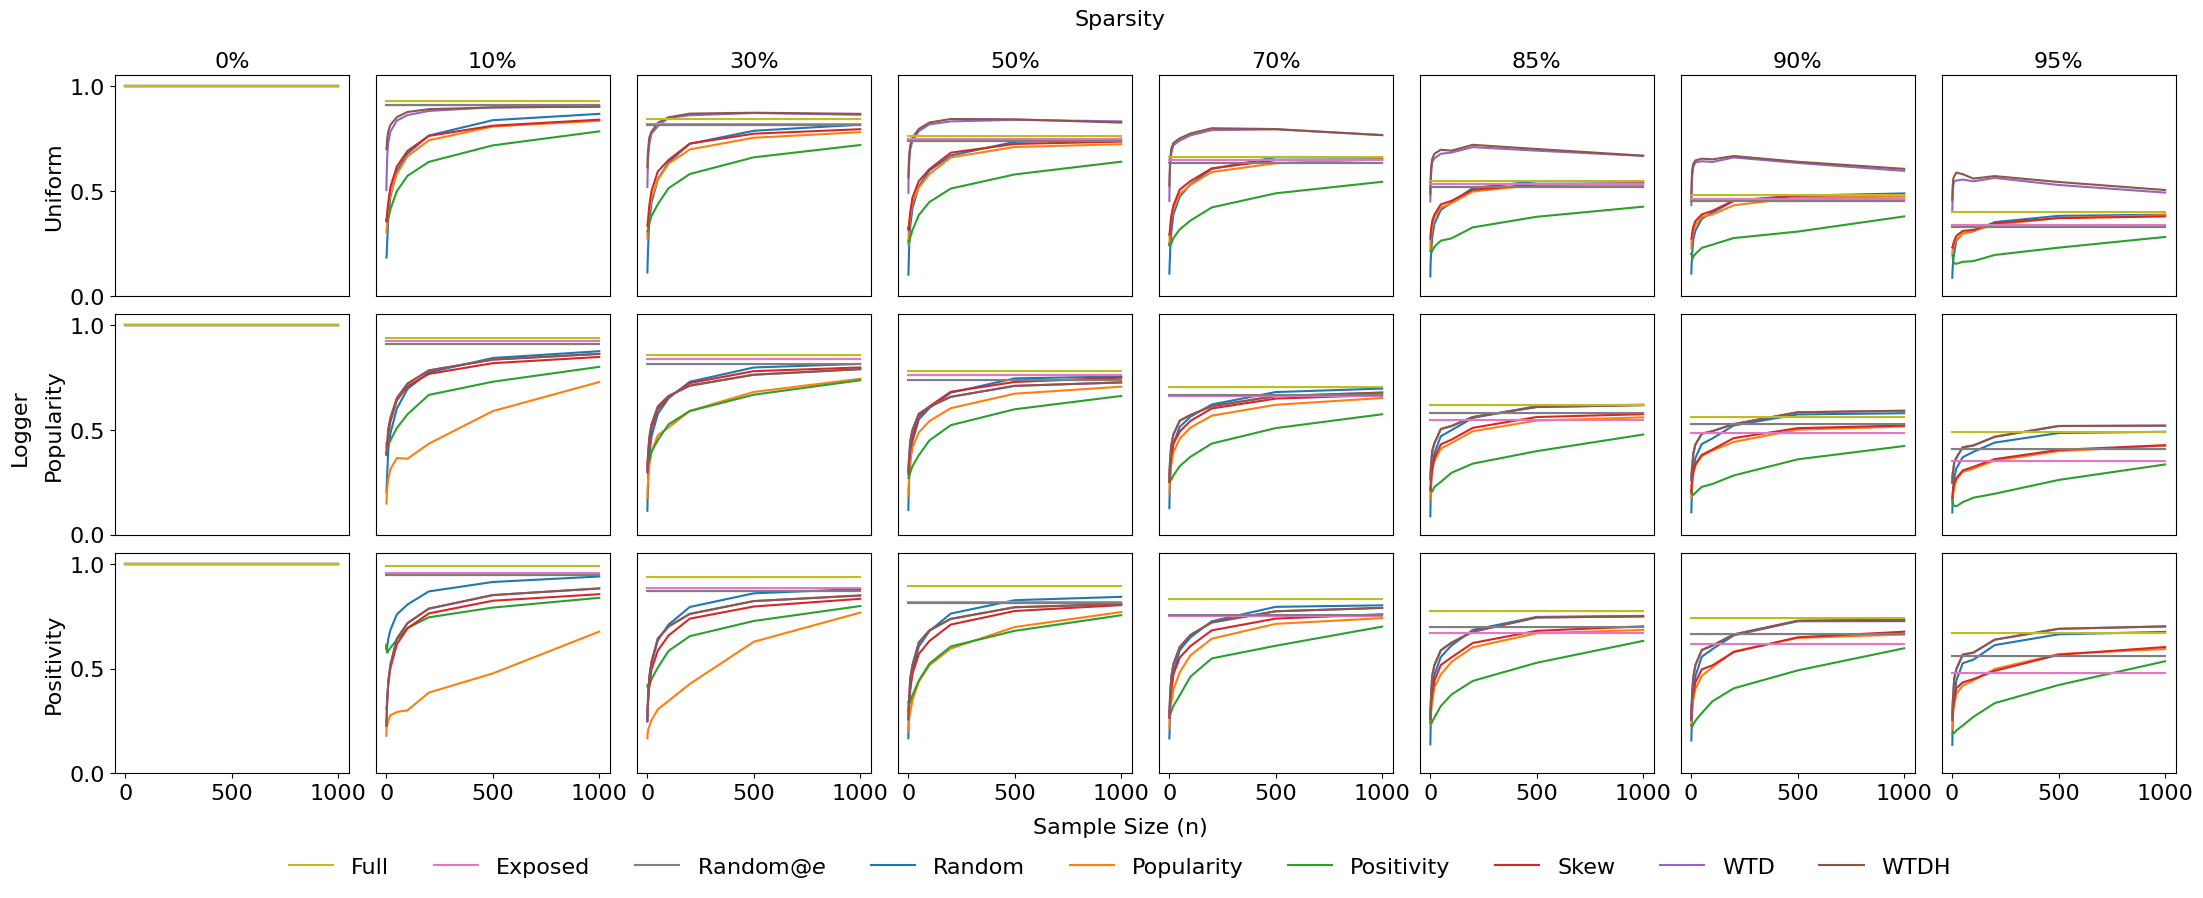

In [ ]:
def format_sampler_name(c, return_at=False):
    if not return_at:
        c = c.split("@")[0]

    c = c.split("-")[-1].replace("CNC", "").capitalize().replace("Randexpo", "Random@$e$")
    if c == "Gt":
        c = "GT"
    if c.startswith("Wtd"):
        c = c.upper()
    if c.startswith("Pop"):
        c = "Popularity"
    if c.startswith("Pos"):
        c = "Positivity"
    
    if "@" in c and return_at:
        c += ("@" + c.split("@")[-1] if return_at else "")
    return c

def sort_legend(handle, labels):
    expected_order = {"GT": 0, "Full": 1, "Exposed": 2, "Random@$e$": 3, "Random": 4, "Popularity": 5, "Positivity": 6, "Skew": 7, "WTD": 8, "WTDH": 9}
    sorted_indices = sorted(range(len(labels)), key=lambda i: expected_order.get(labels[i], len(expected_order)))
    sorted_handles = [handle[i] for i in sorted_indices]
    sorted_labels = [labels[i] for i in sorted_indices]
    return sorted_handles, sorted_labels

plt.rcParams.update({'font.size': 16})

handles = None
labels = None

percentages_to_plot = [0, 10, 30, 50, 70, 85, 90, 95]

ncols = len(bias_types)
fig, axes = plt.subplots(nrows=len(bias_types), ncols=len(percentages_to_plot), figsize=(22, 8))#, width_ratios=[1.05, 1, 1, 1, 1])

default_cols = ["CNCFULL", "EXPOSED", "CNCRANDEXPO"]

for i, biastype in enumerate(bias_types):
    list_corrdf_final = []
    for metric in available_metrics:
        if metric != "ndcg@100":
            continue

        if metric not in q3_kendalldf_by_biastype_metric_biasmodel_samplerblock[bias_type]:
            continue

        corrdf_by_biasmodel_samplerblock = q3_kendalldf_by_biastype_metric_biasmodel_samplerblock[biastype].get(metric)
        if corrdf_by_biasmodel_samplerblock is None:
            continue

        for sampler_block, sampler_order in samplers_blocks.items():
            list_corrdf = []
            for bias, corrdf_by_samplerblock in corrdf_by_biasmodel_samplerblock.items():
                if int("".join([b for b in bias if b.isdigit()])) not in percentages_to_plot:
                    continue
                corrdf = corrdf_by_samplerblock[sampler_block]
                corrdf["bias"] = bias
                list_corrdf.append(corrdf)

            corrdf_aux = (
                pd.concat(list_corrdf)
                .set_index("bias")
            )

            select_cols = default_cols[:] if "RANDOM" in sampler_block else []
            select_cols.extend(corrdf_aux.columns)

            corrdf_aux = (
                corrdf_aux[select_cols]
                .select_dtypes("number")
                .groupby("bias").mean().T
                .rename_axis(None, axis=1)
                .dropna()
                .sort_index(ascending=False, na_position="first", key=lambda s: s.map(sampler_order), axis=0)
                .sort_index(na_position="first", axis=1)
            )

            list_corrdf_final.append(corrdf_aux.rename(lambda c: metric + "-" + c, axis=0))

    corrdf_plot = pd.concat(list_corrdf_final)

    xtickslabels = [str(100 - int("".join([c for c in s if c.isdigit()]))) + "%" for s in corrdf_plot.columns]
    grid_label = "".join([c for c in corrdf_plot.columns[0] if not c.isdigit()]).capitalize()
    if grid_label == "Marpos":
        grid_label = "Positivity"
    if grid_label == "Marpop":
        grid_label = "Popularity"
    if grid_label == "Random":
        grid_label = "Uniform"

    ytickslabels = []
    for c in corrdf_plot.index:
        c = c.split("-")[-1].replace("CNC", "").capitalize().replace("Randexpo", "Rand@$|E_u|$")
        if c == "Gt":
            c = "GT"
        if c.startswith("Wtd"):
            c = c.upper()
        if c.startswith("Rand"):
            c = "Rand@" + c.split("@")[-1]
        if c.startswith("Pop"):
            c = "Pop@" + c.split("@")[-1]
        if c.startswith("Pos"):
            c = "Pos@" + c.split("@")[-1]
        if c.startswith("Full"):
            c = "$L$"
        ytickslabels.append(c)
    ytickslabels2 = [c.split("-")[0] for c in corrdf_plot.index]

    corrdf_plot["sampler"] = corrdf_plot.index.str.split("-").str[-1]
    corrdf_plot["at"] = corrdf_plot["sampler"].apply(lambda s: int(s.split("@")[-1]) if "@" in s else -1)

    no_at_corrdf_plot = corrdf_plot[corrdf_plot["at"] == -1].copy()
    corrdf_plot = corrdf_plot[corrdf_plot["at"] != -1].copy()

    unique_ats = unique(corrdf_plot["at"].values)
    list_new_corrdfs = []
    for at in unique(corrdf_plot["at"].values):
        corrdf_aux = no_at_corrdf_plot.copy()
        corrdf_aux["at"] = at
        list_new_corrdfs.append(corrdf_aux)
    corrdf_plot = pd.concat([corrdf_plot] + list_new_corrdfs)

    corrdf_plot["sampler"] = corrdf_plot["sampler"].apply(lambda s: format_sampler_name(s))
    corrdf_plot = corrdf_plot.query("sampler != 'GT'").copy()
    for j, p in enumerate(percentages_to_plot):
        ax = axes[i][j]
        ax = sns.lineplot(corrdf_plot, x="at", y=biastype + str(p), hue="sampler", ax=ax)
        ax.set_ylim(0, 1.05)
        
        if i == 0:
            ax.set_title(f"{p}%", fontsize=16)
        if i == len(bias_types) - 1:
            ax.set_xlabel("")
        else:
            ax.xaxis.set_tick_params(length=0, labelbottom=False)
            ax.set_xlabel("")
            ax.set_xticklabels([])
        
        if j == 0:
            ax.set_ylabel(grid_label, fontsize=16)
        else:
            ax.yaxis.set_tick_params(length=0, labelbottom=False)
            ax.set_ylabel("")
            ax.set_yticklabels([])

        handles, labels = ax.get_legend_handles_labels()
        ax.legend_.remove()

fig.legend(*sort_legend(handles, labels), loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=len(handles), frameon=False, fontsize=16)
fig.tight_layout(w_pad=0.3, h_pad=0.3)

# Add general labels for the grid
fig.text(0.5, 1.01, "Sparsity", ha='center', va='center', fontsize=16)  # General x-axis label at the 
fig.text(0.5, 0.0, "Sample Size (n)", ha='center', va='center', fontsize=16)  # General x-axis label at the top
fig.text(0.0, 0.5, "Logger", ha='center', va='center', rotation='vertical', fontsize=16)  # General y-axis label

fig.show()

fig.savefig(os.path.join("q3_robustness_line.pdf"), dpi=1300, bbox_inches="tight", pad_inches=0.05)

### Position-Based Kendall Correlation ($G$)

In [23]:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corrwith.html
# {‘pearson’, ‘kendall’, ‘spearman’}
import os
from concurrent.futures import as_completed, ProcessPoolExecutor

q4_kendalldf_by_biastype_metric_biasmodel_samplerblock = {}

def compute_kendalltau(df1, df2, colname, key):
    return key, pd.DataFrame(df1.corrwith(df2, method="kendall", axis=1), columns=[colname])

with ProcessPoolExecutor(max_workers=int(os.cpu_count() * 0.9)) as executor:
    for bias_type, df_by_metric_biasmodel_sampler in df_by_biastype_metric_biasmodel_sampler.items():
        q4_kendalldf_by_biastype_metric_biasmodel_samplerblock[bias_type] = {}
        for metric, df_by_biasmodel_sampler in df_by_metric_biasmodel_sampler.items():
            if ("ndcg" not in metric and "recall" not in metric) or "10" not in metric: # FIXME
                continue

            q4_kendalldf_by_biastype_metric_biasmodel_samplerblock[bias_type][metric] = {}
            for bias, df_by_sampler in df_by_biasmodel_sampler.items():
                q4_kendalldf_by_biastype_metric_biasmodel_samplerblock[bias_type][metric][bias] = {}
                future_to_sampler = []
                for sampler_key, samplers_order in samplers_blocks.items():
                    for sampler1 in samplers_order:
                        rankdf_sampler1 = df_by_sampler[sampler1][recs].rank(
                            axis=1, method="min", numeric_only=True, na_option="bottom", ascending=False
                        ).astype("int")

                        if rankdf_sampler1.shape[0] == 0:
                            continue

                        rankdf_gt = df_by_sampler["GT"][recs].rank(
                            axis=1, method="min", numeric_only=True, na_option="bottom", ascending=False
                        ).astype("int")

                        future_to_sampler.append(
                            executor.submit(
                                compute_kendalltau, rankdf_sampler1, rankdf_gt, sampler1, sampler_key
                            )
                        )

                corrdf_by_samplerkey = {}
                for future in as_completed(future_to_sampler):
                    sampler_key, corr_df = future.result()
                    corrdf_by_samplerkey.setdefault(sampler_key, [])
                    corrdf_by_samplerkey[sampler_key].append(corr_df)

                for sampler_key, list_corr in corrdf_by_samplerkey.items():
                    q4_kendalldf_by_biastype_metric_biasmodel_samplerblock[bias_type][metric][bias][sampler_key] = pd.concat(list_corr, axis=1)

q4_kendalldf_by_biastype_metric_biasmodel_samplerblock[bias_type]["ndcg@100"][bias][sampler_key].head(5)

,WTDH@1,WTDH@5,WTDH@2,WTDH@20,WTDH@200,WTDH@500,GT,WTDH@100,CNCFULL,CNCRANDEXPO,WTDH@10,WTDH@50,EXPOSED,WTDH@1000
0,0.415168,0.181848,0.327327,0.400066,0.400066,0.185185,1.0,0.181848,0.192450,0.036370,0.109109,0.472805,-0.109109,0.115470
1,-0.188713,0.618284,0.222222,0.909241,0.836502,0.925926,1.0,0.981981,0.777778,0.909241,0.836502,0.909241,0.763763,0.851852
2,0.117851,0.254588,0.230940,0.181848,0.109109,0.333333,1.0,0.109109,0.500370,0.181848,0.181848,0.254588,0.036370,0.481481
3,0.370370,0.472805,0.592593,0.909241,0.763763,0.851852,1.0,0.763763,0.777778,0.545545,0.691023,0.909241,0.472805,0.777778
4,0.076980,0.400066,0.000000,0.327327,0.400066,0.333333,1.0,0.400066,0.738549,0.400066,0.327327,0.327327,0.545545,0.629630


#### Q4: Predictive Power

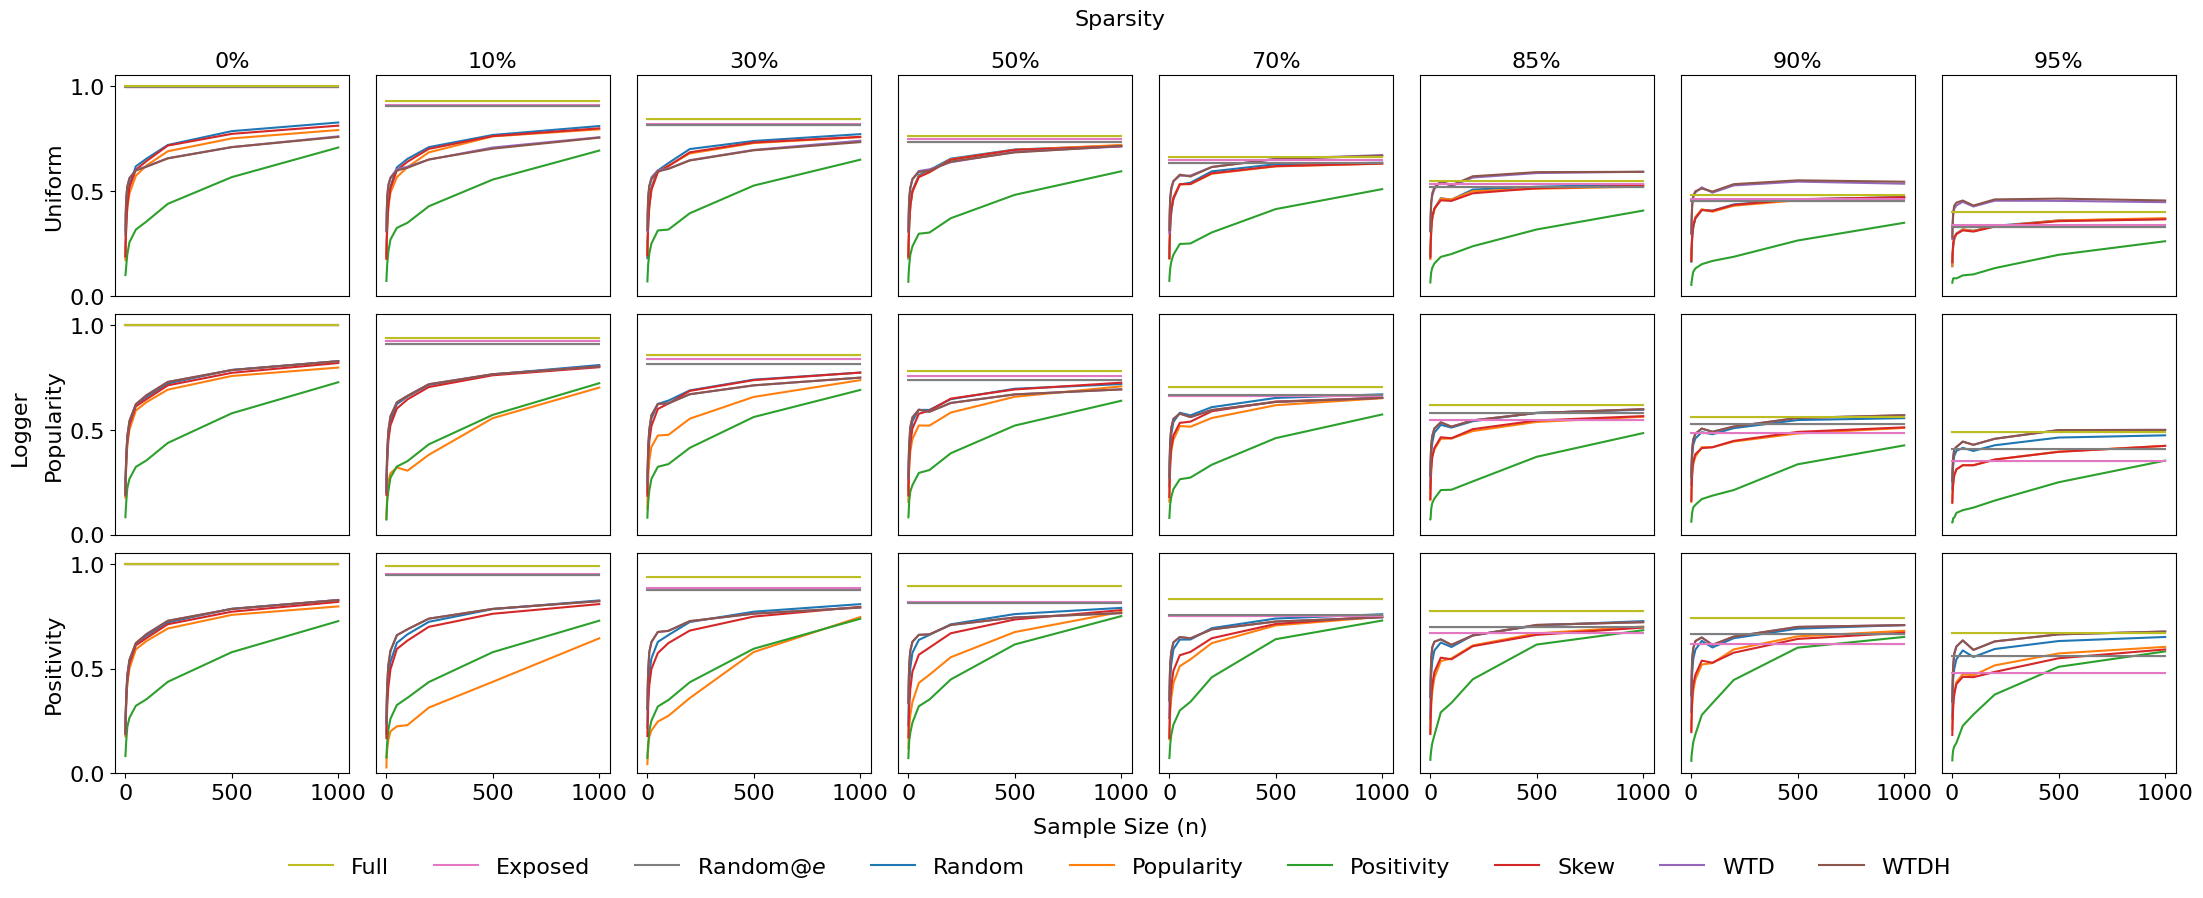

In [ ]:
def format_sampler_name(c, return_at=False):
    if not return_at:
        c = c.split("@")[0]

    c = c.split("-")[-1].replace("CNC", "").capitalize().replace("Randexpo", "Random@$e$")
    if c == "Gt":
        c = "GT"
    if c.startswith("Wtd"):
        c = c.upper()
    if c.startswith("Pop"):
        c = "Popularity"
    if c.startswith("Pos"):
        c = "Positivity"
    
    if "@" in c and return_at:
        c += ("@" + c.split("@")[-1] if return_at else "")
    return c

def sort_legend(handle, labels):
    expected_order = {"GT": 0, "Full": 1, "Exposed": 2, "Random@$e$": 3, "Random": 4, "Popularity": 5, "Positivity": 6, "Skew": 7, "WTD": 8, "WTDH": 9}
    sorted_indices = sorted(range(len(labels)), key=lambda i: expected_order.get(labels[i], len(expected_order)))
    sorted_handles = [handle[i] for i in sorted_indices]
    sorted_labels = [labels[i] for i in sorted_indices]
    return sorted_handles, sorted_labels

plt.rcParams.update({'font.size': 16})

handles = None
labels = None
percentages_to_plot = [0, 10, 30, 50, 70, 85, 90, 95]

ncols = len(bias_types)
fig, axes = plt.subplots(nrows=len(bias_types), ncols=len(percentages_to_plot), figsize=(22, 8))#, width_ratios=[1.05, 1, 1, 1, 1])

default_cols = ["CNCFULL", "EXPOSED", "CNCRANDEXPO"]

for i, biastype in enumerate(bias_types):
    list_corrdf_final = []
    for metric in available_metrics:
        if metric != "ndcg@100":
            continue

        if metric not in q4_kendalldf_by_biastype_metric_biasmodel_samplerblock[bias_type]:
            continue

        corrdf_by_biasmodel_samplerblock = q4_kendalldf_by_biastype_metric_biasmodel_samplerblock[biastype].get(metric)
        if corrdf_by_biasmodel_samplerblock is None:
            continue

        for sampler_block, sampler_order in samplers_blocks.items():
            list_corrdf = []
            for bias, corrdf_by_samplerblock in corrdf_by_biasmodel_samplerblock.items():
                if int("".join([b for b in bias if b.isdigit()])) not in percentages_to_plot:
                    continue
                corrdf = corrdf_by_samplerblock[sampler_block]
                corrdf["bias"] = bias
                list_corrdf.append(corrdf)

            corrdf_aux = (
                pd.concat(list_corrdf)
                .set_index("bias")
            )

            select_cols = default_cols[:] if "RANDOM" in sampler_block else []
            select_cols.extend(corrdf_aux.columns)

            corrdf_aux = (
                corrdf_aux[select_cols]
                .select_dtypes("number")
                .groupby("bias").mean().T
                .rename_axis(None, axis=1)
                .dropna()
                .sort_index(ascending=False, na_position="first", key=lambda s: s.map(sampler_order), axis=0)
                .sort_index(na_position="first", axis=1)
            )

            list_corrdf_final.append(corrdf_aux.rename(lambda c: metric + "-" + c, axis=0))

    corrdf_plot = pd.concat(list_corrdf_final)

    xtickslabels = [str(100 - int("".join([c for c in s if c.isdigit()]))) + "%" for s in corrdf_plot.columns]
    grid_label = "".join([c for c in corrdf_plot.columns[0] if not c.isdigit()]).capitalize()
    if grid_label == "Marpos":
        grid_label = "Positivity"
    if grid_label == "Marpop":
        grid_label = "Popularity"
    if grid_label == "Random":
        grid_label = "Uniform"

    ytickslabels = []
    for c in corrdf_plot.index:
        c = c.split("-")[-1].replace("CNC", "").capitalize().replace("Randexpo", "Rand@$|E_u|$")
        if c == "Gt":
            c = "GT"
        if c.startswith("Wtd"):
            c = c.upper()
        if c.startswith("Rand"):
            c = "Rand@" + c.split("@")[-1]
        if c.startswith("Pop"):
            c = "Pop@" + c.split("@")[-1]
        if c.startswith("Pos"):
            c = "Pos@" + c.split("@")[-1]
        if c.startswith("Full"):
            c = "$L$"
        ytickslabels.append(c)
    ytickslabels2 = [c.split("-")[0] for c in corrdf_plot.index]

    corrdf_plot["sampler"] = corrdf_plot.index.str.split("-").str[-1]
    corrdf_plot["at"] = corrdf_plot["sampler"].apply(lambda s: int(s.split("@")[-1]) if "@" in s else -1)

    no_at_corrdf_plot = corrdf_plot[corrdf_plot["at"] == -1].copy()
    corrdf_plot = corrdf_plot[corrdf_plot["at"] != -1].copy()

    unique_ats = unique(corrdf_plot["at"].values)
    list_new_corrdfs = []
    for at in unique(corrdf_plot["at"].values):
        corrdf_aux = no_at_corrdf_plot.copy()
        corrdf_aux["at"] = at
        list_new_corrdfs.append(corrdf_aux)
    corrdf_plot = pd.concat([corrdf_plot] + list_new_corrdfs)

    corrdf_plot["sampler"] = corrdf_plot["sampler"].apply(lambda s: format_sampler_name(s))
    corrdf_plot = corrdf_plot.query("sampler != 'GT'").copy()
    for j, p in enumerate(percentages_to_plot):
        ax = axes[i][j]
        ax = sns.lineplot(corrdf_plot, x="at", y=biastype + str(p), hue="sampler", ax=ax)
        ax.set_ylim(0, 1.05)
        
        if i == 0:
            ax.set_title(f"{p}%", fontsize=16)
        if i == len(bias_types) - 1:
            ax.set_xlabel("")
        else:
            ax.xaxis.set_tick_params(length=0, labelbottom=False)
            ax.set_xlabel("")
            ax.set_xticklabels([])
        
        if j == 0:
            ax.set_ylabel(grid_label, fontsize=16)
        else:
            ax.yaxis.set_tick_params(length=0, labelbottom=False)
            ax.set_ylabel("")
            ax.set_yticklabels([])

        handles, labels = ax.get_legend_handles_labels()
        ax.legend_.remove()

fig.legend(*sort_legend(handles, labels), loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=len(handles), frameon=False, fontsize=16)
fig.tight_layout(w_pad=0.3, h_pad=0.3)

# Add general labels for the grid
fig.text(0.5, 1.01, "Sparsity", ha='center', va='center', fontsize=16)  # General x-axis label at the 
fig.text(0.5, 0.0, "Sample Size (n)", ha='center', va='center', fontsize=16)  # General x-axis label at the top
fig.text(0.0, 0.5, "Logger", ha='center', va='center', rotation='vertical', fontsize=16)  # General y-axis label

fig.show()

fig.savefig(os.path.join("q4_predictiv_power_line.pdf"), dpi=1300, bbox_inches="tight", pad_inches=0.05)